In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import imutils

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Reading Images

In [3]:
list_scenes = os.listdir('Images')

img_list = []
count_image = 0
count_scene = 0
dict_image = {}

for i in list_scenes:    
    try:
        list_images = os.listdir('Images/%s'%(i))
        count_scene += 1
        
        for j in list_images:
            if j != '.DS_Store':                
                img = cv2.imread('Images/%s/%s'%(i,j), cv2.IMREAD_GRAYSCALE)
                img_list.append(img)
                
                dict_image[count_image] = count_scene
                count_image += 1
    except:
        pass

### Resizing Images

In [4]:
def resize_img(img):
    return imutils.resize(img, width=1024)

In [5]:
img_list = [resize_img(img) for img in img_list]

### Get SIFT and ORB features 

In [6]:
orb = cv2.ORB_create(nfeatures = 200)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 200)

In [7]:
def get_sift(img):
    keypoints_sift, descriptors_sift = sift.detectAndCompute(img, None)
    return descriptors_sift

def get_orb(img):
    keypoints_orb, descriptors_orb = orb.detectAndCompute(img, None)
    return descriptors_orb

In [8]:
img_desc_list_sift = [get_sift(img) for img in img_list]
img_desc_list_orb = [get_orb(img) for img in img_list]

### Get distance between two images using k features

In [9]:
from scipy import spatial

def distance(k, descriptors1, descriptors2):
    tree = spatial.KDTree(descriptors2)
    
    nearest_distances = []
    for i in descriptors1:
        nearest_distances.append(tree.query(i)[0])
    
    nearest_distances.sort()
    
    return sum(nearest_distances[:k])   

def get_img_distances(k, img_list, img_desc_list):
    img_dist = np.zeros((len(img_list),len(img_list)))

    for i, w in enumerate(img_desc_list):
        for j, u in enumerate(img_desc_list):
            if j > i:
                img_dist[i][j] = distance(k, w, u)

    for i, w in enumerate(img_dist):
        for j, u in enumerate(img_dist):
            if i > j:
                img_dist[i][j] = img_dist[j][i]
                
    return img_dist

In [10]:
img_dist_orb = get_img_distances(10, img_list, img_desc_list_orb)
img_dist_sift = get_img_distances(10, img_list, img_desc_list_sift)

### Accuracy 

In [11]:
def mean_accuracy(img_dist, dict_image):
    accuracy = []
    for i,w in enumerate(img_dist):
        idx = np.argpartition(w, 6)
        idx = [j for j in idx[:6] if j != i]

        ground_label = dict_image[i]
        count = 0

        for j in idx:
            if dict_image[j] == ground_label:
                count += 1
        accuracy.append(count)
        
    return sum(accuracy)/float(len(accuracy))

In [12]:
mean_orb = mean_accuracy(img_dist_orb, dict_image)
mean_sift = mean_accuracy(img_dist_sift, dict_image)

In [13]:
print('For K=10 -->','\nMean Accuracy with ORB =','%.2f'%(mean_orb),'\nMean Accuracy with SIFT =', '%.2f'%(mean_sift))

For K=10 --> 
Mean Accuracy with ORB = 3.89 
Mean Accuracy with SIFT = 4.44


### Main Function

In [14]:
def run(which_features, k, img_list, dict_image):
    
    if which_features == 'sift':
        img_desc_list = [get_sift(img) for img in img_list]
    else:
        img_desc_list = [get_orb(img) for img in img_list]
        
    img_dist = get_img_distances(k, img_list, img_desc_list)
    mean = mean_accuracy(img_dist, dict_image)
    
    return mean*100/5.0

### Graph for K = [1,5,10,20,40,60,80] and max matches = 200

In [15]:
K = [1,5,10,20,40,60,80,200] 
print('Time Statistics for ORB')
%time accuracy_orb = [run('orb', k, img_list, dict_image) for k in K]   #ORB
print('\n\nTime Statistics for SIFT')
%time accuracy_sift = [run('sift', k, img_list, dict_image) for k in K] #SIFT

Time Statistics for ORB
CPU times: user 53.8 s, sys: 188 ms, total: 54 s
Wall time: 53.5 s


Time Statistics for SIFT

CPU times: user 11min 46s, sys: 16.9 s, total: 12min 3s
Wall time: 12min 21s


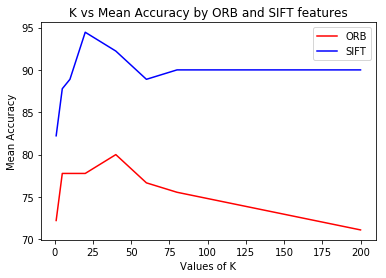

In [16]:
plt.plot(K, accuracy_orb, 'r', label='ORB')
plt.plot(K, accuracy_sift, 'b', label='SIFT')
plt.xlabel('Values of K')
plt.ylabel('Mean Accuracy')

plt.legend()
plt.title('K vs Mean Accuracy by ORB and SIFT features')
plt.show()

### SIFT is performing better than ORB in terms of accuracy 
- Might be because SIFT has 128 dimensional feature while ORB has only 32 dimensional feature

### ORB is performing better than SIFT in terms of time 